In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 134

cuda:1


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
# # standardize based on each batch
for i in range(len(train_input)):
    train_input[i] = (train_input[i]-np.mean(train_input[i], 0))/(np.std(train_input[i], 0)+1)

# for i in range(len(train_output)):
#     train_output[i] = (train_output[i]-np.mean(train_output[i]))/np.std(train_output[i])

for i in range(len(val_input)):
    val_input[i] = (val_input[i]-np.mean(val_input[i], 0))/(np.std(val_input[i], 0)+1)

# for i in range(len(val_output)):
#     val_output[i] = (val_output[i]-np.mean(val_output[i]))/np.std(val_output[i])

for i in range(len(test_input)):
    test_input[i] = (test_input[i]-np.mean(test_input[i], 0))/(np.std(test_input[i], 0)+1)

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)


In [24]:
# train_input = (train_input - np.reshape(np.mean(train_input, 1), (train_input.shape[0], 1)))/np.reshape(np.std(train_input, 1), (train_input.shape[0], 1))
# val_input = (val_input - np.reshape(np.mean(val_input, 1), (val_input.shape[0], 1)))/np.reshape(np.std(val_input, 1), (val_input.shape[0], 1))
# test_input = (test_input - np.reshape(np.mean(test_input, 1), (test_input.shape[0], 1)))/np.reshape(np.std(test_input, 1), (test_input.shape[0], 1))

In [25]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [26]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [27]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [28]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [29]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [30]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [31]:
batch_train = batch_train + batch_val

In [32]:
train_output = train_output[:, 0:pred_num]
train_output.shape

torch.Size([66175, 134])

In [33]:
val_output = val_output[:, 0:pred_num]
val_output.shape

torch.Size([28921, 134])

In [34]:
test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 134])

In [35]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [36]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [37]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//8)
        self.linear2 = nn.Linear(input_feature//8, input_feature//16)
        self.linear3 = nn.Linear(input_feature//16, input_feature//32)
        self.linear4 = nn.Linear(input_feature//32, input_feature//64)
        
        self.linear5 = nn.Linear(input_feature//8, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [38]:
PATH = 'Batch_feature_norm_model_2'

In [39]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (10, 4*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.22032727  Validation_loss:  0.21475929  Test_loss:  0.4629368


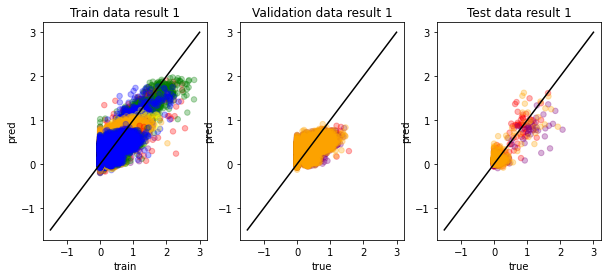

Epoch  100 Train_loss:  0.21994582  Validation_loss:  0.2144503  Test_loss:  0.46306285
Epoch  200 Train_loss:  0.21954961  Validation_loss:  0.21412876  Test_loss:  0.46311244
Epoch  300 Train_loss:  0.21915962  Validation_loss:  0.2138153  Test_loss:  0.4631804
Epoch  400 Train_loss:  0.21876545  Validation_loss:  0.21349259  Test_loss:  0.46322098
Epoch  500 Train_loss:  0.21837643  Validation_loss:  0.2131802  Test_loss:  0.4633869
Epoch  600 Train_loss:  0.21798511  Validation_loss:  0.2128592  Test_loss:  0.46338972
Epoch  700 Train_loss:  0.21759504  Validation_loss:  0.21254112  Test_loss:  0.46341166
Epoch  800 Train_loss:  0.21721153  Validation_loss:  0.21222624  Test_loss:  0.46350682
Epoch  900 Train_loss:  0.2168238  Validation_loss:  0.21190818  Test_loss:  0.46365386
Epoch  1000 Train_loss:  0.21643989  Validation_loss:  0.21158986  Test_loss:  0.46367288


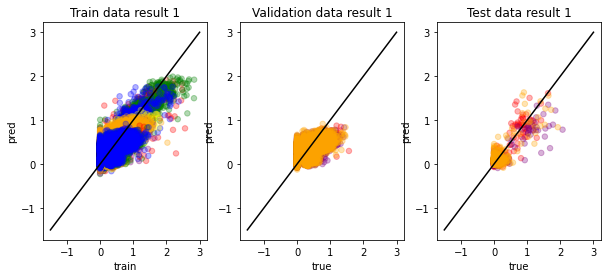

Epoch  1100 Train_loss:  0.21606651  Validation_loss:  0.21128483  Test_loss:  0.4636936
Epoch  1200 Train_loss:  0.21568471  Validation_loss:  0.21096472  Test_loss:  0.46397474
Epoch  1300 Train_loss:  0.21531002  Validation_loss:  0.21065488  Test_loss:  0.46396255
Epoch  1400 Train_loss:  0.21493158  Validation_loss:  0.21034135  Test_loss:  0.46402892
Epoch  1500 Train_loss:  0.21455832  Validation_loss:  0.21002913  Test_loss:  0.4640199
Epoch  1600 Train_loss:  0.2141882  Validation_loss:  0.2097207  Test_loss:  0.464334
Epoch  1700 Train_loss:  0.21381293  Validation_loss:  0.20940895  Test_loss:  0.4640934
Epoch  1800 Train_loss:  0.21344472  Validation_loss:  0.20910124  Test_loss:  0.46428618
Epoch  1900 Train_loss:  0.21308255  Validation_loss:  0.20879592  Test_loss:  0.4644505
Epoch  2000 Train_loss:  0.21271408  Validation_loss:  0.20848481  Test_loss:  0.46452495


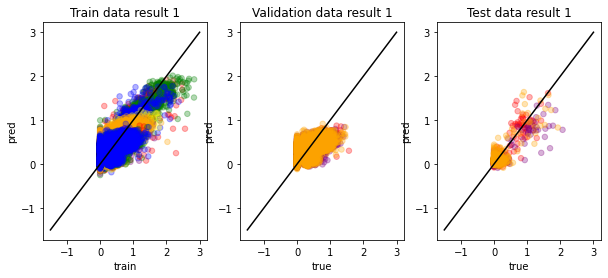

Epoch  2100 Train_loss:  0.21235588  Validation_loss:  0.20818423  Test_loss:  0.4646191
Epoch  2200 Train_loss:  0.21199097  Validation_loss:  0.2078762  Test_loss:  0.46457407
Epoch  2300 Train_loss:  0.21163677  Validation_loss:  0.20757684  Test_loss:  0.46470734
Epoch  2400 Train_loss:  0.21127424  Validation_loss:  0.2072753  Test_loss:  0.46461374
Epoch  2500 Train_loss:  0.21091816  Validation_loss:  0.20696846  Test_loss:  0.46482295
Epoch  2600 Train_loss:  0.21055378  Validation_loss:  0.20666213  Test_loss:  0.46487364
Epoch  2700 Train_loss:  0.2102089  Validation_loss:  0.20636715  Test_loss:  0.46499124
Epoch  2800 Train_loss:  0.2098515  Validation_loss:  0.20606272  Test_loss:  0.46500334
Epoch  2900 Train_loss:  0.20949568  Validation_loss:  0.20575996  Test_loss:  0.46520254
Epoch  3000 Train_loss:  0.20914826  Validation_loss:  0.2054644  Test_loss:  0.46505907


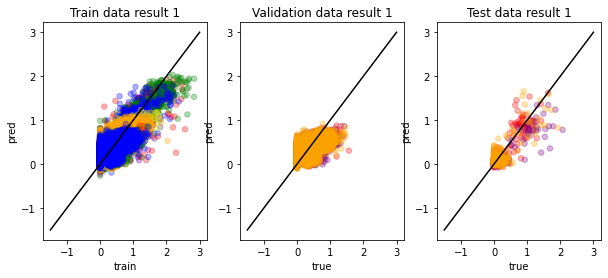

Epoch  3100 Train_loss:  0.2087947  Validation_loss:  0.20516123  Test_loss:  0.4650918
Epoch  3200 Train_loss:  0.20845538  Validation_loss:  0.20487225  Test_loss:  0.46526048
Epoch  3300 Train_loss:  0.20811006  Validation_loss:  0.20457463  Test_loss:  0.46547207
Epoch  3400 Train_loss:  0.20776525  Validation_loss:  0.20427899  Test_loss:  0.4654529
Epoch  3500 Train_loss:  0.2074149  Validation_loss:  0.20397866  Test_loss:  0.46557236
Epoch  3600 Train_loss:  0.20707628  Validation_loss:  0.20368472  Test_loss:  0.46565336
Epoch  3700 Train_loss:  0.20673996  Validation_loss:  0.203399  Test_loss:  0.4657854
Epoch  3800 Train_loss:  0.20639668  Validation_loss:  0.20310482  Test_loss:  0.46592996
Epoch  3900 Train_loss:  0.20606208  Validation_loss:  0.20281474  Test_loss:  0.46574733
Epoch  4000 Train_loss:  0.20572264  Validation_loss:  0.20251904  Test_loss:  0.46602303


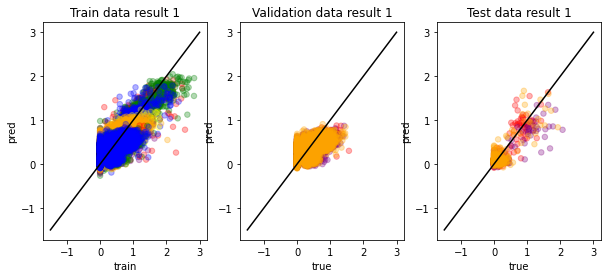

Epoch  4100 Train_loss:  0.20538518  Validation_loss:  0.20222977  Test_loss:  0.46590266
Epoch  4200 Train_loss:  0.20505217  Validation_loss:  0.20194337  Test_loss:  0.46616292
Epoch  4300 Train_loss:  0.20471686  Validation_loss:  0.20165169  Test_loss:  0.4662488
Epoch  4400 Train_loss:  0.20437935  Validation_loss:  0.20136322  Test_loss:  0.46617457
Epoch  4500 Train_loss:  0.20404838  Validation_loss:  0.20107292  Test_loss:  0.46641216
Epoch  4600 Train_loss:  0.20372568  Validation_loss:  0.20079336  Test_loss:  0.4663924
Epoch  4700 Train_loss:  0.20340149  Validation_loss:  0.20051192  Test_loss:  0.4664338
Epoch  4800 Train_loss:  0.20307088  Validation_loss:  0.20022686  Test_loss:  0.4665674
Epoch  4900 Train_loss:  0.20274526  Validation_loss:  0.19994293  Test_loss:  0.46653765
Epoch  5000 Train_loss:  0.20241524  Validation_loss:  0.19965644  Test_loss:  0.46646756


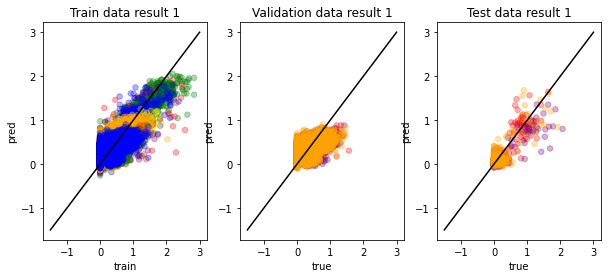

Epoch  5100 Train_loss:  0.20209637  Validation_loss:  0.19938177  Test_loss:  0.46675098
Epoch  5200 Train_loss:  0.20177475  Validation_loss:  0.19909944  Test_loss:  0.46676198
Epoch  5300 Train_loss:  0.2014476  Validation_loss:  0.19881466  Test_loss:  0.4669384
Epoch  5400 Train_loss:  0.20112689  Validation_loss:  0.19852935  Test_loss:  0.46672317
Epoch  5500 Train_loss:  0.2008186  Validation_loss:  0.19826731  Test_loss:  0.46697146
Epoch  5600 Train_loss:  0.20049952  Validation_loss:  0.19798574  Test_loss:  0.46703726
Epoch  5700 Train_loss:  0.20018236  Validation_loss:  0.19770792  Test_loss:  0.46692845
Epoch  5800 Train_loss:  0.19986607  Validation_loss:  0.19743276  Test_loss:  0.46723413
Epoch  5900 Train_loss:  0.19954841  Validation_loss:  0.19715017  Test_loss:  0.46714008
Epoch  6000 Train_loss:  0.19922508  Validation_loss:  0.19686617  Test_loss:  0.4673403


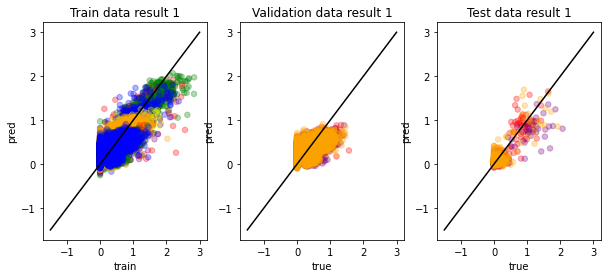

Epoch  6100 Train_loss:  0.19892319  Validation_loss:  0.19660649  Test_loss:  0.46737632
Epoch  6200 Train_loss:  0.19862524  Validation_loss:  0.1963458  Test_loss:  0.46753368
Epoch  6300 Train_loss:  0.19830422  Validation_loss:  0.19606201  Test_loss:  0.46745035
Epoch  6400 Train_loss:  0.19800478  Validation_loss:  0.19579773  Test_loss:  0.46765998
Epoch  6500 Train_loss:  0.19768229  Validation_loss:  0.1955144  Test_loss:  0.46761274
Epoch  6600 Train_loss:  0.19738169  Validation_loss:  0.19524677  Test_loss:  0.46767887
Epoch  6700 Train_loss:  0.19708268  Validation_loss:  0.19498372  Test_loss:  0.46778312
Epoch  6800 Train_loss:  0.19677383  Validation_loss:  0.1947112  Test_loss:  0.46767607
Epoch  6900 Train_loss:  0.1964691  Validation_loss:  0.19443838  Test_loss:  0.4677611
Epoch  7000 Train_loss:  0.19617054  Validation_loss:  0.1941776  Test_loss:  0.467863


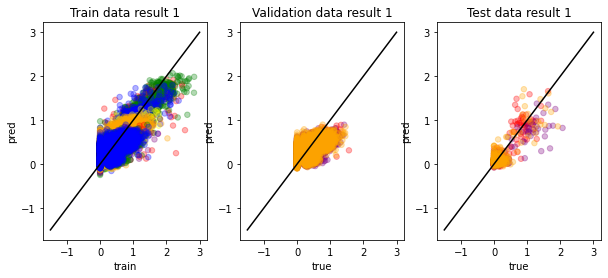

Epoch  7100 Train_loss:  0.19587082  Validation_loss:  0.19391608  Test_loss:  0.46785215
Epoch  7200 Train_loss:  0.19556452  Validation_loss:  0.19363879  Test_loss:  0.4680606
Epoch  7300 Train_loss:  0.1952699  Validation_loss:  0.19337735  Test_loss:  0.46812075
Epoch  7400 Train_loss:  0.19497217  Validation_loss:  0.19311246  Test_loss:  0.46809107
Epoch  7500 Train_loss:  0.19468157  Validation_loss:  0.19285277  Test_loss:  0.4681585
Epoch  7600 Train_loss:  0.19438754  Validation_loss:  0.1925946  Test_loss:  0.4683101
Epoch  7700 Train_loss:  0.19409019  Validation_loss:  0.19232753  Test_loss:  0.46829066
Epoch  7800 Train_loss:  0.19379205  Validation_loss:  0.19205755  Test_loss:  0.46836415
Epoch  7900 Train_loss:  0.19349776  Validation_loss:  0.19179769  Test_loss:  0.4684388
Epoch  8000 Train_loss:  0.19320872  Validation_loss:  0.19153751  Test_loss:  0.46863073


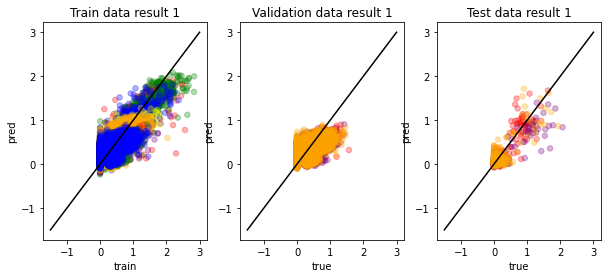

Epoch  8100 Train_loss:  0.19291735  Validation_loss:  0.1912761  Test_loss:  0.46859464
Epoch  8200 Train_loss:  0.19264106  Validation_loss:  0.19102883  Test_loss:  0.46876398
Epoch  8300 Train_loss:  0.19234134  Validation_loss:  0.19075876  Test_loss:  0.46880457
Epoch  8400 Train_loss:  0.19205213  Validation_loss:  0.19050309  Test_loss:  0.46853468
Epoch  8500 Train_loss:  0.19177045  Validation_loss:  0.19024396  Test_loss:  0.46888116
Epoch  8600 Train_loss:  0.19148226  Validation_loss:  0.18998368  Test_loss:  0.46883705
Epoch  8700 Train_loss:  0.19120243  Validation_loss:  0.18973011  Test_loss:  0.46891963
Epoch  8800 Train_loss:  0.19092292  Validation_loss:  0.18947631  Test_loss:  0.46897534
Epoch  8900 Train_loss:  0.19063647  Validation_loss:  0.18921837  Test_loss:  0.4689791
Epoch  9000 Train_loss:  0.1903436  Validation_loss:  0.18895651  Test_loss:  0.46912882


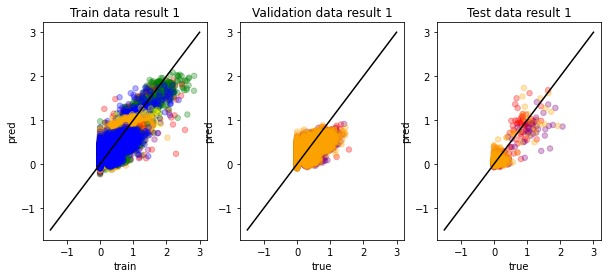

Epoch  9100 Train_loss:  0.19007106  Validation_loss:  0.18870312  Test_loss:  0.46916294
Epoch  9200 Train_loss:  0.18980563  Validation_loss:  0.18846646  Test_loss:  0.46921554
Epoch  9300 Train_loss:  0.18950942  Validation_loss:  0.18819475  Test_loss:  0.4693182
Epoch  9400 Train_loss:  0.18923916  Validation_loss:  0.18795241  Test_loss:  0.46940735
Epoch  9500 Train_loss:  0.18895479  Validation_loss:  0.187692  Test_loss:  0.46942493
Epoch  9600 Train_loss:  0.18868501  Validation_loss:  0.18744582  Test_loss:  0.46969676
Epoch  9700 Train_loss:  0.18841214  Validation_loss:  0.18719336  Test_loss:  0.4697142
Epoch  9800 Train_loss:  0.18813905  Validation_loss:  0.18694264  Test_loss:  0.46980065
Epoch  9900 Train_loss:  0.18786103  Validation_loss:  0.186687  Test_loss:  0.46965387
Epoch  10000 Train_loss:  0.18758921  Validation_loss:  0.18644102  Test_loss:  0.46979123


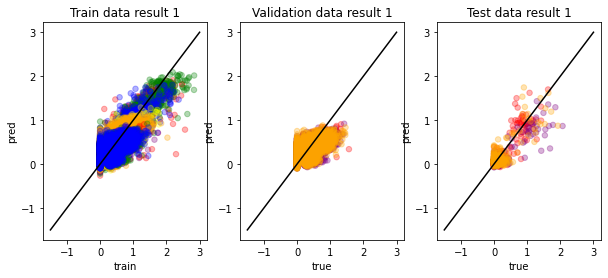

Epoch  10100 Train_loss:  0.18732205  Validation_loss:  0.18619032  Test_loss:  0.4698007
Epoch  10200 Train_loss:  0.1870502  Validation_loss:  0.18594208  Test_loss:  0.47003615
Epoch  10300 Train_loss:  0.18677153  Validation_loss:  0.18568309  Test_loss:  0.46991456
Epoch  10400 Train_loss:  0.18650171  Validation_loss:  0.18543684  Test_loss:  0.46990383
Epoch  10500 Train_loss:  0.18624808  Validation_loss:  0.18519716  Test_loss:  0.47016189
Epoch  10600 Train_loss:  0.1859711  Validation_loss:  0.1849445  Test_loss:  0.46999702
Epoch  10700 Train_loss:  0.18571462  Validation_loss:  0.18470831  Test_loss:  0.47027063
Epoch  10800 Train_loss:  0.18544547  Validation_loss:  0.18446013  Test_loss:  0.4703156
Epoch  10900 Train_loss:  0.18518735  Validation_loss:  0.18422008  Test_loss:  0.4703972
Epoch  11000 Train_loss:  0.18491568  Validation_loss:  0.18396407  Test_loss:  0.4704378


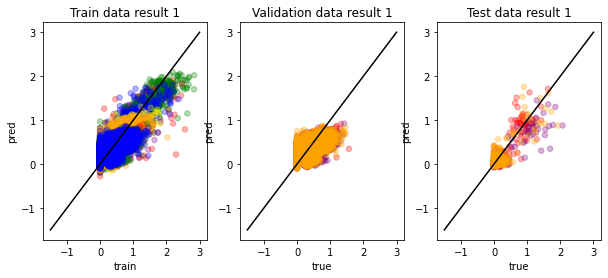

Epoch  11100 Train_loss:  0.18465795  Validation_loss:  0.18372287  Test_loss:  0.47043803
Epoch  11200 Train_loss:  0.18438824  Validation_loss:  0.18347068  Test_loss:  0.4704495
Epoch  11300 Train_loss:  0.1841327  Validation_loss:  0.18323681  Test_loss:  0.47067896
Epoch  11400 Train_loss:  0.18386908  Validation_loss:  0.18298842  Test_loss:  0.47069913
Epoch  11500 Train_loss:  0.18362159  Validation_loss:  0.18275662  Test_loss:  0.47078094
Epoch  11600 Train_loss:  0.1833544  Validation_loss:  0.18250535  Test_loss:  0.470767
Epoch  11700 Train_loss:  0.18308245  Validation_loss:  0.18225466  Test_loss:  0.4707456
Epoch  11800 Train_loss:  0.18284243  Validation_loss:  0.18202993  Test_loss:  0.47099054
Epoch  11900 Train_loss:  0.18258186  Validation_loss:  0.18178329  Test_loss:  0.47103077
Epoch  12000 Train_loss:  0.18232307  Validation_loss:  0.18153791  Test_loss:  0.47108063


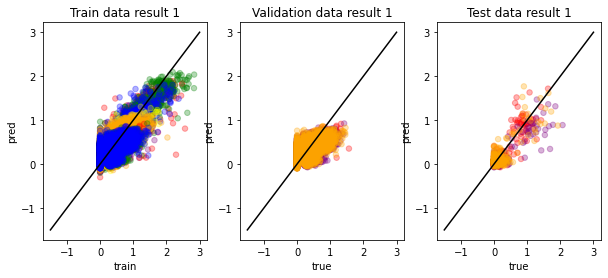

Epoch  12100 Train_loss:  0.18207356  Validation_loss:  0.18130346  Test_loss:  0.47112015
Epoch  12200 Train_loss:  0.18181716  Validation_loss:  0.18106289  Test_loss:  0.47111207
Epoch  12300 Train_loss:  0.18156366  Validation_loss:  0.1808235  Test_loss:  0.4712052
Epoch  12400 Train_loss:  0.18131158  Validation_loss:  0.18058479  Test_loss:  0.47125888
Epoch  12500 Train_loss:  0.18105605  Validation_loss:  0.18034498  Test_loss:  0.47142947
Epoch  12600 Train_loss:  0.18080235  Validation_loss:  0.18010375  Test_loss:  0.47133487
Epoch  12700 Train_loss:  0.18055409  Validation_loss:  0.17986697  Test_loss:  0.47140032
Epoch  12800 Train_loss:  0.18029748  Validation_loss:  0.17962457  Test_loss:  0.4715451
Epoch  12900 Train_loss:  0.18006395  Validation_loss:  0.17940511  Test_loss:  0.47173536
Epoch  13000 Train_loss:  0.17981116  Validation_loss:  0.17916778  Test_loss:  0.471615


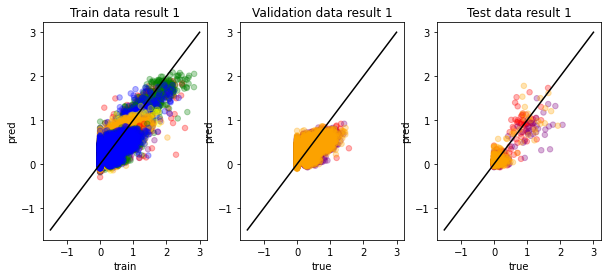

Epoch  13100 Train_loss:  0.17955461  Validation_loss:  0.1789228  Test_loss:  0.47174668
Epoch  13200 Train_loss:  0.17931041  Validation_loss:  0.17869326  Test_loss:  0.47175413
Epoch  13300 Train_loss:  0.17906615  Validation_loss:  0.17845932  Test_loss:  0.4717889
Epoch  13400 Train_loss:  0.17882018  Validation_loss:  0.17822598  Test_loss:  0.4718608
Epoch  13500 Train_loss:  0.17857595  Validation_loss:  0.17799062  Test_loss:  0.47201148
Epoch  13600 Train_loss:  0.17833853  Validation_loss:  0.17776267  Test_loss:  0.47201774
Epoch  13700 Train_loss:  0.17808229  Validation_loss:  0.17752315  Test_loss:  0.47205094
Epoch  13800 Train_loss:  0.17785227  Validation_loss:  0.1773028  Test_loss:  0.4721659
Epoch  13900 Train_loss:  0.17761087  Validation_loss:  0.17707002  Test_loss:  0.47225872
Epoch  14000 Train_loss:  0.17736684  Validation_loss:  0.17683811  Test_loss:  0.47227523


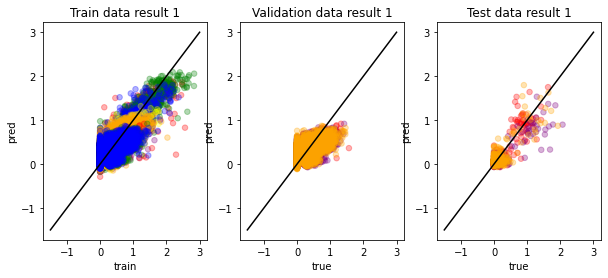

Epoch  14100 Train_loss:  0.17712109  Validation_loss:  0.17660488  Test_loss:  0.47231963
Epoch  14200 Train_loss:  0.17687944  Validation_loss:  0.17637354  Test_loss:  0.47237933
Epoch  14300 Train_loss:  0.17665112  Validation_loss:  0.17615384  Test_loss:  0.47263652
Epoch  14400 Train_loss:  0.17640692  Validation_loss:  0.17591836  Test_loss:  0.47262973
Epoch  14500 Train_loss:  0.17615941  Validation_loss:  0.17568034  Test_loss:  0.4727074
Epoch  14600 Train_loss:  0.17593111  Validation_loss:  0.17546107  Test_loss:  0.4727401
Epoch  14700 Train_loss:  0.1756916  Validation_loss:  0.17523368  Test_loss:  0.47273847
Epoch  14800 Train_loss:  0.1754622  Validation_loss:  0.17501625  Test_loss:  0.47284514
Epoch  14900 Train_loss:  0.17522553  Validation_loss:  0.1747919  Test_loss:  0.47280648
Epoch  15000 Train_loss:  0.17498866  Validation_loss:  0.1745594  Test_loss:  0.47286075


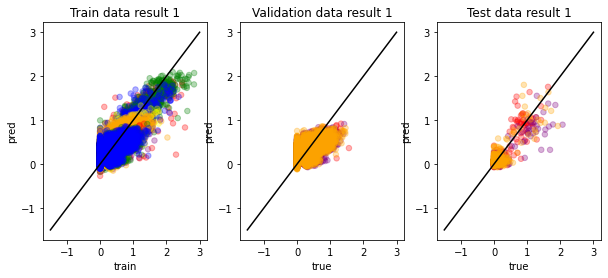

Epoch  15100 Train_loss:  0.17475629  Validation_loss:  0.17434354  Test_loss:  0.47296366
Epoch  15200 Train_loss:  0.17451292  Validation_loss:  0.17410196  Test_loss:  0.47303015
Epoch  15300 Train_loss:  0.17428994  Validation_loss:  0.17388628  Test_loss:  0.47329146
Epoch  15400 Train_loss:  0.17406397  Validation_loss:  0.17367105  Test_loss:  0.4732865
Epoch  15500 Train_loss:  0.17382371  Validation_loss:  0.17343773  Test_loss:  0.47330338
Epoch  15600 Train_loss:  0.17359349  Validation_loss:  0.1732158  Test_loss:  0.47343713
Epoch  15700 Train_loss:  0.17336327  Validation_loss:  0.17299438  Test_loss:  0.47330534
Epoch  15800 Train_loss:  0.1731201  Validation_loss:  0.17276092  Test_loss:  0.47335562
Epoch  15900 Train_loss:  0.17291693  Validation_loss:  0.17256431  Test_loss:  0.47361764
Epoch  16000 Train_loss:  0.17268397  Validation_loss:  0.17234208  Test_loss:  0.47352478


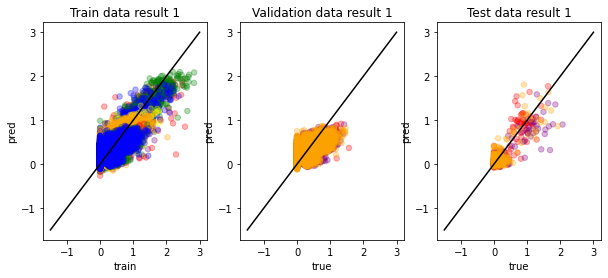

Epoch  16100 Train_loss:  0.17245859  Validation_loss:  0.17212407  Test_loss:  0.4736552
Epoch  16200 Train_loss:  0.17222708  Validation_loss:  0.17190084  Test_loss:  0.47375298
Epoch  16300 Train_loss:  0.17200615  Validation_loss:  0.1716832  Test_loss:  0.47372058
Epoch  16400 Train_loss:  0.17177081  Validation_loss:  0.17145891  Test_loss:  0.47383454
Epoch  16500 Train_loss:  0.17154762  Validation_loss:  0.17124511  Test_loss:  0.47373483
Epoch  16600 Train_loss:  0.17132434  Validation_loss:  0.17103332  Test_loss:  0.4738962
Epoch  16700 Train_loss:  0.17110015  Validation_loss:  0.17081064  Test_loss:  0.4739921
Epoch  16800 Train_loss:  0.17088167  Validation_loss:  0.17059585  Test_loss:  0.47395587
Epoch  16900 Train_loss:  0.17065525  Validation_loss:  0.17038046  Test_loss:  0.47418275
Epoch  17000 Train_loss:  0.17043129  Validation_loss:  0.17016502  Test_loss:  0.47405502


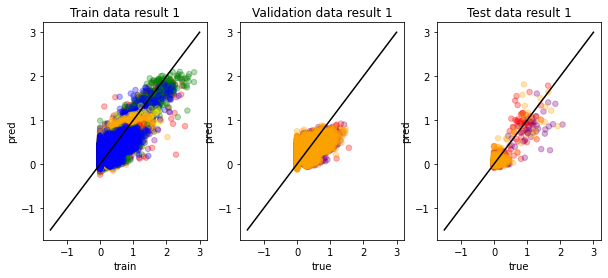

Epoch  17100 Train_loss:  0.17021915  Validation_loss:  0.16996247  Test_loss:  0.47428468
Epoch  17200 Train_loss:  0.16998954  Validation_loss:  0.16973598  Test_loss:  0.47421768
Epoch  17300 Train_loss:  0.16978596  Validation_loss:  0.16953808  Test_loss:  0.47433344
Epoch  17400 Train_loss:  0.1695635  Validation_loss:  0.1693229  Test_loss:  0.47447658
Epoch  17500 Train_loss:  0.16934693  Validation_loss:  0.16911119  Test_loss:  0.47435564
Epoch  17600 Train_loss:  0.16913046  Validation_loss:  0.16890466  Test_loss:  0.47468024
Epoch  17700 Train_loss:  0.16890697  Validation_loss:  0.16868901  Test_loss:  0.47459087
Epoch  17800 Train_loss:  0.16869497  Validation_loss:  0.16847835  Test_loss:  0.47462115
Epoch  17900 Train_loss:  0.16848396  Validation_loss:  0.16827786  Test_loss:  0.4747203
Epoch  18000 Train_loss:  0.16827644  Validation_loss:  0.1680772  Test_loss:  0.47455987


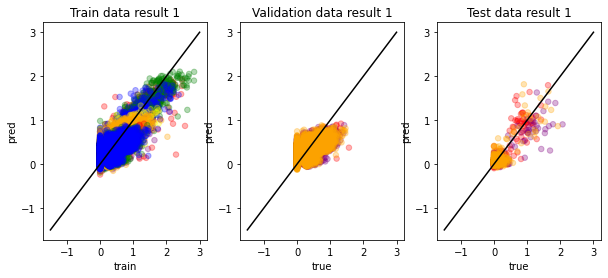

Epoch  18100 Train_loss:  0.16805081  Validation_loss:  0.16785699  Test_loss:  0.4748723
Epoch  18200 Train_loss:  0.16783744  Validation_loss:  0.16765065  Test_loss:  0.47471637
Epoch  18300 Train_loss:  0.1676246  Validation_loss:  0.16744584  Test_loss:  0.47480276
Epoch  18400 Train_loss:  0.16741511  Validation_loss:  0.16723986  Test_loss:  0.47510323
Epoch  18500 Train_loss:  0.16720872  Validation_loss:  0.16703893  Test_loss:  0.4749426
Epoch  18600 Train_loss:  0.16699955  Validation_loss:  0.16684009  Test_loss:  0.47501042
Epoch  18700 Train_loss:  0.1667868  Validation_loss:  0.16663025  Test_loss:  0.47506186
Epoch  18800 Train_loss:  0.16658458  Validation_loss:  0.16643761  Test_loss:  0.4751704
Epoch  18900 Train_loss:  0.1663785  Validation_loss:  0.16623132  Test_loss:  0.47536778
Epoch  19000 Train_loss:  0.16615891  Validation_loss:  0.166024  Test_loss:  0.4752583


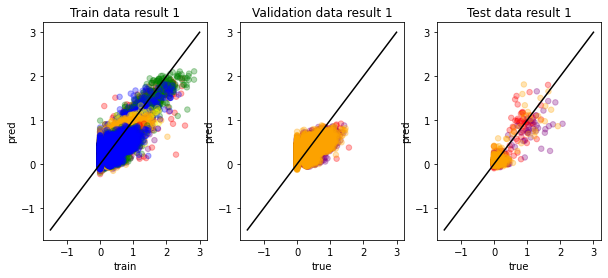

Epoch  19100 Train_loss:  0.16596161  Validation_loss:  0.1658278  Test_loss:  0.4752607
Epoch  19200 Train_loss:  0.16575614  Validation_loss:  0.16562828  Test_loss:  0.47542137
Epoch  19300 Train_loss:  0.16555007  Validation_loss:  0.16542998  Test_loss:  0.4755297
Epoch  19400 Train_loss:  0.16534059  Validation_loss:  0.16522458  Test_loss:  0.47548357
Epoch  19500 Train_loss:  0.1651479  Validation_loss:  0.16503796  Test_loss:  0.47562125
Epoch  19600 Train_loss:  0.16494086  Validation_loss:  0.16483548  Test_loss:  0.4756527
Epoch  19700 Train_loss:  0.1647394  Validation_loss:  0.16464496  Test_loss:  0.47577795
Epoch  19800 Train_loss:  0.16454373  Validation_loss:  0.16444919  Test_loss:  0.47579336
Epoch  19900 Train_loss:  0.16432942  Validation_loss:  0.16424313  Test_loss:  0.4758
Epoch  20000 Train_loss:  0.16413179  Validation_loss:  0.16405258  Test_loss:  0.47575596


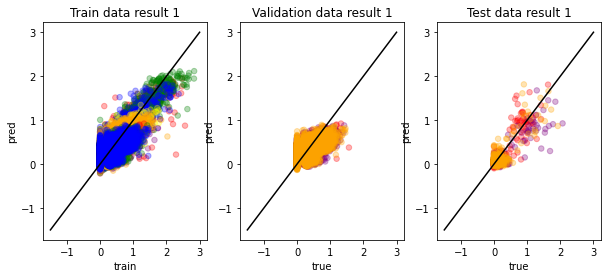

Epoch  20100 Train_loss:  0.16392176  Validation_loss:  0.16384426  Test_loss:  0.47588283
Epoch  20200 Train_loss:  0.16373478  Validation_loss:  0.16366288  Test_loss:  0.4760619
Epoch  20300 Train_loss:  0.16353008  Validation_loss:  0.1634615  Test_loss:  0.47595778
Epoch  20400 Train_loss:  0.16333582  Validation_loss:  0.16327523  Test_loss:  0.47623974
Epoch  20500 Train_loss:  0.16314438  Validation_loss:  0.16309081  Test_loss:  0.47604448
Epoch  20600 Train_loss:  0.16295524  Validation_loss:  0.16290693  Test_loss:  0.47619697
Epoch  20700 Train_loss:  0.16274484  Validation_loss:  0.16270466  Test_loss:  0.4762445
Epoch  20800 Train_loss:  0.16253844  Validation_loss:  0.16250232  Test_loss:  0.47623813
Epoch  20900 Train_loss:  0.16235411  Validation_loss:  0.16232088  Test_loss:  0.47625363
Epoch  21000 Train_loss:  0.1621523  Validation_loss:  0.16212325  Test_loss:  0.47640896


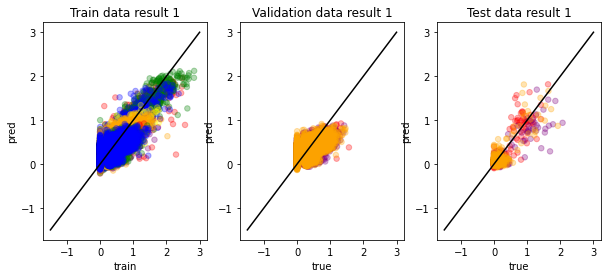

Epoch  21100 Train_loss:  0.16196318  Validation_loss:  0.16194546  Test_loss:  0.4763531
Epoch  21200 Train_loss:  0.1617628  Validation_loss:  0.16174792  Test_loss:  0.47658664
Epoch  21300 Train_loss:  0.16158229  Validation_loss:  0.16157177  Test_loss:  0.4765445
Epoch  21400 Train_loss:  0.16137415  Validation_loss:  0.16136889  Test_loss:  0.47664285
Epoch  21500 Train_loss:  0.1611853  Validation_loss:  0.16118398  Test_loss:  0.47661453
Epoch  21600 Train_loss:  0.16099593  Validation_loss:  0.16100378  Test_loss:  0.47653174
Epoch  21700 Train_loss:  0.16080576  Validation_loss:  0.16081485  Test_loss:  0.47663686
Epoch  21800 Train_loss:  0.16062136  Validation_loss:  0.1606368  Test_loss:  0.47658354
Epoch  21900 Train_loss:  0.1604267  Validation_loss:  0.16044658  Test_loss:  0.47668004
Epoch  22000 Train_loss:  0.16023207  Validation_loss:  0.16025801  Test_loss:  0.476839


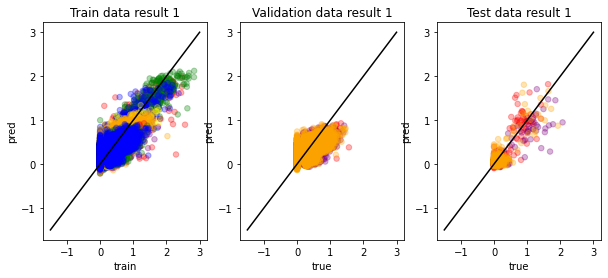

Epoch  22100 Train_loss:  0.16004615  Validation_loss:  0.16007794  Test_loss:  0.47672915
Epoch  22200 Train_loss:  0.15985008  Validation_loss:  0.15988803  Test_loss:  0.47689456
Epoch  22300 Train_loss:  0.15966398  Validation_loss:  0.15970483  Test_loss:  0.47699803
Epoch  22400 Train_loss:  0.15947348  Validation_loss:  0.15951873  Test_loss:  0.476931
Epoch  22500 Train_loss:  0.15929112  Validation_loss:  0.15933926  Test_loss:  0.4769781
Epoch  22600 Train_loss:  0.1590915  Validation_loss:  0.15914905  Test_loss:  0.47708791
Epoch  22700 Train_loss:  0.15890989  Validation_loss:  0.15896884  Test_loss:  0.47728446
Epoch  22800 Train_loss:  0.15872991  Validation_loss:  0.15879358  Test_loss:  0.47700512
Epoch  22900 Train_loss:  0.15853448  Validation_loss:  0.15860176  Test_loss:  0.47728375
Epoch  23000 Train_loss:  0.15833871  Validation_loss:  0.15841436  Test_loss:  0.47728875


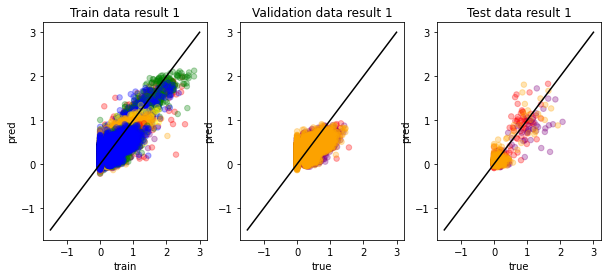

Epoch  23100 Train_loss:  0.1581663  Validation_loss:  0.15824889  Test_loss:  0.47739276
Epoch  23200 Train_loss:  0.1579665  Validation_loss:  0.1580477  Test_loss:  0.47731996
Epoch  23300 Train_loss:  0.15779123  Validation_loss:  0.15787375  Test_loss:  0.477413
Epoch  23400 Train_loss:  0.15760198  Validation_loss:  0.15769261  Test_loss:  0.47755176
Epoch  23500 Train_loss:  0.1574135  Validation_loss:  0.15751  Test_loss:  0.47751316
Epoch  23600 Train_loss:  0.1572326  Validation_loss:  0.15733404  Test_loss:  0.47772026
Epoch  23700 Train_loss:  0.15704148  Validation_loss:  0.15714207  Test_loss:  0.47770244
Epoch  23800 Train_loss:  0.15686367  Validation_loss:  0.15697065  Test_loss:  0.47771633
Epoch  23900 Train_loss:  0.15667866  Validation_loss:  0.15679264  Test_loss:  0.47763833
Epoch  24000 Train_loss:  0.15649454  Validation_loss:  0.15660815  Test_loss:  0.47779045


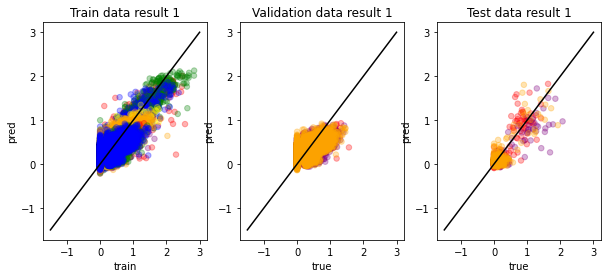

Epoch  24100 Train_loss:  0.1563116  Validation_loss:  0.15643303  Test_loss:  0.4778154
Epoch  24200 Train_loss:  0.15612307  Validation_loss:  0.15624362  Test_loss:  0.47778964
Epoch  24300 Train_loss:  0.15593998  Validation_loss:  0.15606473  Test_loss:  0.47789514
Epoch  24400 Train_loss:  0.15575776  Validation_loss:  0.15588824  Test_loss:  0.47805926
Epoch  24500 Train_loss:  0.15557656  Validation_loss:  0.15570772  Test_loss:  0.47792116
Epoch  24600 Train_loss:  0.15538053  Validation_loss:  0.15551548  Test_loss:  0.47802058
Epoch  24700 Train_loss:  0.15521082  Validation_loss:  0.1553467  Test_loss:  0.47808662
Epoch  24800 Train_loss:  0.155026  Validation_loss:  0.15516876  Test_loss:  0.47811392
Epoch  24900 Train_loss:  0.154842  Validation_loss:  0.15498154  Test_loss:  0.4781822
Epoch  25000 Train_loss:  0.15466955  Validation_loss:  0.15481356  Test_loss:  0.47826338


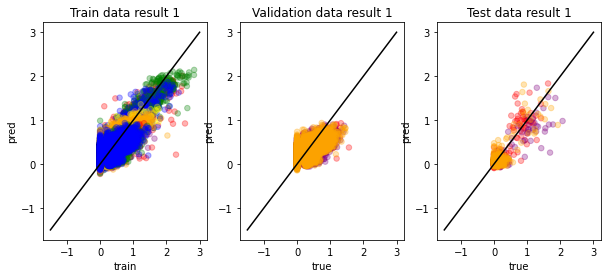

Epoch  25100 Train_loss:  0.15449008  Validation_loss:  0.15463823  Test_loss:  0.4783562
Epoch  25200 Train_loss:  0.15428431  Validation_loss:  0.15443407  Test_loss:  0.4782976
Epoch  25300 Train_loss:  0.15411729  Validation_loss:  0.15427142  Test_loss:  0.47837272
Epoch  25400 Train_loss:  0.15394308  Validation_loss:  0.15410315  Test_loss:  0.4784004
Epoch  25500 Train_loss:  0.15374568  Validation_loss:  0.15390933  Test_loss:  0.4784383
Epoch  25600 Train_loss:  0.15357544  Validation_loss:  0.15373628  Test_loss:  0.47849688
Epoch  25700 Train_loss:  0.1533854  Validation_loss:  0.15355161  Test_loss:  0.4785758
Epoch  25800 Train_loss:  0.15321127  Validation_loss:  0.15337662  Test_loss:  0.47860137
Epoch  25900 Train_loss:  0.15303653  Validation_loss:  0.15320335  Test_loss:  0.47868875
Epoch  26000 Train_loss:  0.15285935  Validation_loss:  0.15303367  Test_loss:  0.47871774


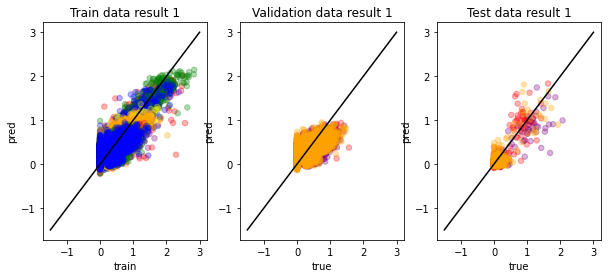

Epoch  26100 Train_loss:  0.15265325  Validation_loss:  0.15282261  Test_loss:  0.47881767
Epoch  26200 Train_loss:  0.15249495  Validation_loss:  0.15267082  Test_loss:  0.47896805
Epoch  26300 Train_loss:  0.15230894  Validation_loss:  0.15248354  Test_loss:  0.47887588
Epoch  26400 Train_loss:  0.15213977  Validation_loss:  0.15231797  Test_loss:  0.47883335
Epoch  26500 Train_loss:  0.1519544  Validation_loss:  0.15213262  Test_loss:  0.4790127
Epoch  26600 Train_loss:  0.15177827  Validation_loss:  0.1519593  Test_loss:  0.47903395
Epoch  26700 Train_loss:  0.15159266  Validation_loss:  0.15177697  Test_loss:  0.47892487
Epoch  26800 Train_loss:  0.15141049  Validation_loss:  0.15159346  Test_loss:  0.47918335
Epoch  26900 Train_loss:  0.15123203  Validation_loss:  0.1514151  Test_loss:  0.47918972
Epoch  27000 Train_loss:  0.15106902  Validation_loss:  0.15125437  Test_loss:  0.47923696


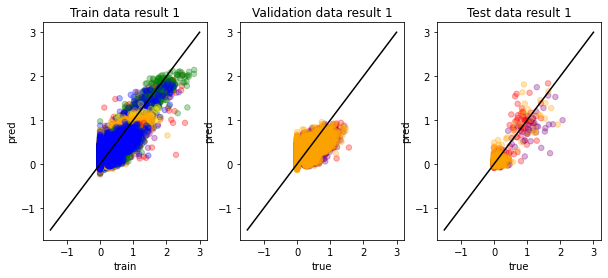

Epoch  27100 Train_loss:  0.15088639  Validation_loss:  0.15107498  Test_loss:  0.47917068
Epoch  27200 Train_loss:  0.15072161  Validation_loss:  0.15090895  Test_loss:  0.47945383
Epoch  27300 Train_loss:  0.15053597  Validation_loss:  0.15071957  Test_loss:  0.47927824
Epoch  27400 Train_loss:  0.15035611  Validation_loss:  0.15054618  Test_loss:  0.47939274
Epoch  27500 Train_loss:  0.15018208  Validation_loss:  0.15037245  Test_loss:  0.47948813
Epoch  27600 Train_loss:  0.14999358  Validation_loss:  0.15018536  Test_loss:  0.47954077
Epoch  27700 Train_loss:  0.14982347  Validation_loss:  0.15001336  Test_loss:  0.47951448
Epoch  27800 Train_loss:  0.14965248  Validation_loss:  0.14984792  Test_loss:  0.47954965
Epoch  27900 Train_loss:  0.14947626  Validation_loss:  0.14967285  Test_loss:  0.479784
Epoch  28000 Train_loss:  0.14929481  Validation_loss:  0.14949013  Test_loss:  0.47959033


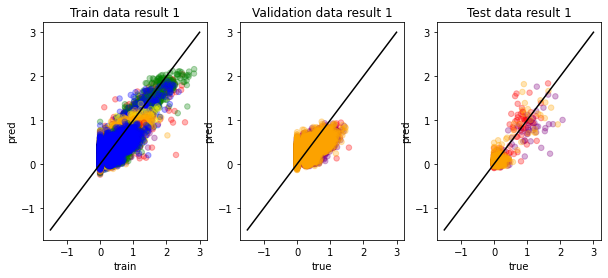

Epoch  28100 Train_loss:  0.14911504  Validation_loss:  0.14930941  Test_loss:  0.47968727
Epoch  28200 Train_loss:  0.14894548  Validation_loss:  0.1491399  Test_loss:  0.4797753
Epoch  28300 Train_loss:  0.14877439  Validation_loss:  0.14897071  Test_loss:  0.4797684
Epoch  28400 Train_loss:  0.14860786  Validation_loss:  0.1488052  Test_loss:  0.47988954
Epoch  28500 Train_loss:  0.14842321  Validation_loss:  0.1486222  Test_loss:  0.47990623
Epoch  28600 Train_loss:  0.1482491  Validation_loss:  0.14844763  Test_loss:  0.48000494
Epoch  28700 Train_loss:  0.14807391  Validation_loss:  0.14827695  Test_loss:  0.4799371
Epoch  28800 Train_loss:  0.14789544  Validation_loss:  0.14809062  Test_loss:  0.4801275
Epoch  28900 Train_loss:  0.14773437  Validation_loss:  0.14792836  Test_loss:  0.48016107
Epoch  29000 Train_loss:  0.14754798  Validation_loss:  0.14774977  Test_loss:  0.48023129


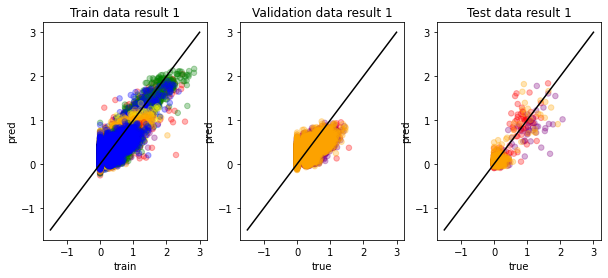

Epoch  29100 Train_loss:  0.14738816  Validation_loss:  0.1475856  Test_loss:  0.48020837
Epoch  29200 Train_loss:  0.14721118  Validation_loss:  0.14741252  Test_loss:  0.48021737
Epoch  29300 Train_loss:  0.14704157  Validation_loss:  0.14724103  Test_loss:  0.48026815
Epoch  29400 Train_loss:  0.14686985  Validation_loss:  0.14706689  Test_loss:  0.48046398
Epoch  29500 Train_loss:  0.14668411  Validation_loss:  0.1468832  Test_loss:  0.48026696
Epoch  29600 Train_loss:  0.14652608  Validation_loss:  0.14672163  Test_loss:  0.4804595
Epoch  29700 Train_loss:  0.14634718  Validation_loss:  0.14654295  Test_loss:  0.48040318
Epoch  29800 Train_loss:  0.14619476  Validation_loss:  0.14639117  Test_loss:  0.48057243
Epoch  29900 Train_loss:  0.1460078  Validation_loss:  0.14620583  Test_loss:  0.48066592
Epoch  30000 Train_loss:  0.14583224  Validation_loss:  0.14603037  Test_loss:  0.48057857


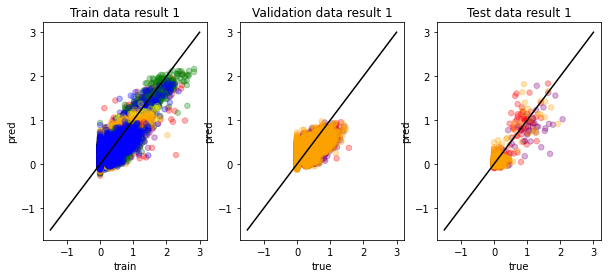

Epoch  30100 Train_loss:  0.1456558  Validation_loss:  0.1458512  Test_loss:  0.48073408
Epoch  30200 Train_loss:  0.14549994  Validation_loss:  0.14570232  Test_loss:  0.48075393
Epoch  30300 Train_loss:  0.14533427  Validation_loss:  0.14553247  Test_loss:  0.48081714
Epoch  30400 Train_loss:  0.14515774  Validation_loss:  0.14535184  Test_loss:  0.48070666
Epoch  30500 Train_loss:  0.14498433  Validation_loss:  0.14518212  Test_loss:  0.48075244
Epoch  30600 Train_loss:  0.14480945  Validation_loss:  0.1450063  Test_loss:  0.48089027
Epoch  30700 Train_loss:  0.14464606  Validation_loss:  0.14484608  Test_loss:  0.48087686
Epoch  30800 Train_loss:  0.14448392  Validation_loss:  0.14468089  Test_loss:  0.4808315
Epoch  30900 Train_loss:  0.14430888  Validation_loss:  0.14450392  Test_loss:  0.4809846
Epoch  31000 Train_loss:  0.14414653  Validation_loss:  0.1443382  Test_loss:  0.48099887


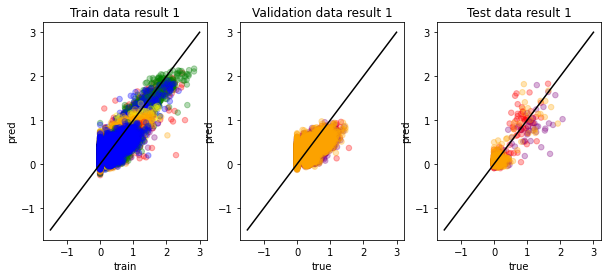

Epoch  31100 Train_loss:  0.1439753  Validation_loss:  0.14416955  Test_loss:  0.48104754


In [ ]:
num_epochs = 50000
learning_rate = 0.1
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)